In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
#from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.utils import load_img, img_to_array 
from keras_preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
# from keras.layers.merge import add

import random
import collections
import json
from tqdm.notebook import tqdm
import os

In [4]:
model_base = "/content/drive/MyDrive/Restnet50_LSTM_coco/"
dataset_text = "/content/drive/MyDrive/coco/annotations/"
dataset_images = "/content/drive/MyDrive/coco/train2014/"

# Reading the Description file
annotation_file = dataset_text + "captions_train2014.json"
with open(annotation_file, 'r') as f:
      annotations = json.load(f)

In [5]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 
def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [6]:
##########################
image_to_captions = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"{val['caption']}"
    image_name = 'COCO_train2014_' + '%012d' % (val['image_id'])
    image_to_captions[image_name].append(clean_text(caption))
    
print(image_to_captions['COCO_train2014_000000000078']) 

['lighted owl candle sits next to clock', 'white clock sitting next to statue of an owl', 'close up of clock near an owl candle holder', 'an antique looking clock beside an owl with candle in it', 'an owl candle and clock sitting in front of wall']


In [7]:
# #########################
saved_path = model_base + "saved/"

with open(saved_path + "descriptions.txt","w") as capt_write_file:
     capt_write_file.write(json.dumps(image_to_captions))

f.close()

In [8]:
#############################
#  reading description file

f = open(saved_path + "/" + "descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [9]:
###########################
# finding the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 22803


In [10]:
#############################
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print('all_vocab',all_vocab[:15])

Vocabulary Size: 3647209
all_vocab ['very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom', 'blue', 'and', 'white', 'bathroom', 'with', 'butterfly', 'themed', 'wall']


In [11]:
#########################################
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 5

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

print('len vocab',len(all_vocab))

len vocab 7971


In [24]:
#################################
# Set list images of training set (30k) and test set (5k)

image_paths = list(image_to_captions.keys())
random.shuffle(image_paths)

train = image_paths[:8000]

f = open(saved_path + "train_images_list.txt","w")
f.write( str(train))
f.close()

test = image_paths[8000:9000]
f = open(saved_path + "test_images_list.txt","w")
f.write( str(test))
f.close()

In [25]:
####################################
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

test_descriptions = {}

for t in test:
    test_descriptions[t] = []
    for cap in descriptions[t]:
       test_descriptions[t].append(cap)

# train_descriptions['COCO_train2014_000000197503']

In [26]:
###################################
"""
In this section, we will load our images and do some processing so that we can feed it in our network.
"""
# model = ResNet50(weights=model_base + "../" +"resnet50_weights_tf_dim_ordering_tf_kernels.h5", input_shape=(224,224,3))
model = ResNet50(input_shape=(224,224,3))
# print(model.summary())

In [27]:
##################################
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [28]:
#################################
images = dataset_images
storage = saved_path + "storage/"

In [29]:
###############################
def preprocess_image(img):
    img = load_img(img, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [30]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [32]:
######################################
from os.path import exists

start = time()

encoding_train = {}
if(not exists(storage+"encoded_train_coco50_images.pkl")):
    for ix, img in tqdm(enumerate(train)):

        img = images + "/{}.jpg".format(train[ix])
        encoding_train[img[len(images):]] = encode_image(img)

        # if ix%5000==0:
        #     print("Encoding image- "+ str(ix))
        #     print("\n" + img)
extract_time = time()-start

result_file = saved_path + 'result.txt'
file = open(result_file,"w")
file.write('time_featurize:\n')
file.write(str(extract_time))
file.close()

print("Encoding train Time taken in seconds =", extract_time)


# Save the bottleneck train features to disk
if(not exists(storage+"encoded_train_coco50_images.pkl")):
    with open(storage+"encoded_train_coco50_images.pkl", "wb") as encoded_pickle:
        pickle.dump(encoding_train, encoded_pickle)

0it [00:00, ?it/s]

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 95ms/step
Encoding train Time taken in seconds = 1000.9684891700745


FileNotFoundError: ignored

In [34]:
#####################################
start = time()

encoding_test = {}
if(not exists(storage+"encoded_test_coco50_images.pkl")):
    for ix, img in tqdm(enumerate(test)):

        img = images + "/{}.jpg".format(test[ix])
        encoding_test[img[len(images):]] = encode_image(img)

        # if ix%1000==0:
        #     print("Encoding image- "+ str(ix)+":"+ img)
time_extract_test = time()-start  

file = open(result_file,"a")
file.write('\nextract test time:\n')
file.write(str(time_extract_test))
file.close()

print("Encoding test Time taken in seconds =", time_extract_test)


# Save the bottleneck train features to disk
if(not exists(storage+"encoded_test_coco50_images.pkl")):
    with open(storage+ "encoded_test_coco50_images.pkl", "wb") as encoded_pickle:
        pickle.dump(encoding_test, encoded_pickle)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 71ms/step
Encoding test Time taken in seconds = 401.066077709198


In [35]:
############################################
# Load the train images features from disk

with open(storage + "encoded_train_coco50_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

# Load the test images features from disk

with open(storage + "encoded_test_coco50_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [36]:
################################################
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1  

print('len vocab', len(all_vocab))

len vocab 7971


In [37]:
###############################################
#  need to add these 2 words as well

word_to_idx['startseq'] = len(all_vocab)
word_to_idx['endseq'] = len(all_vocab) + 1

idx_to_word[len(all_vocab)] = 'startseq'
idx_to_word[len(all_vocab)+1] = 'endseq'

In [38]:
#############################################
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

7973


In [39]:
#############################################
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print('max len',max_len)

max len 43


In [40]:
###########################################
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1
            #print(key + " - " + desc_list[0])
            photo = encoding_train['/' + key+".jpg"] #[key+".jpg"]
            
            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [41]:
########################################################
# Download Word Embedding from Kaggle 
# https://www.kaggle.com/watts2/glove6b50dtxt

f = open(saved_path+ "glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [42]:
############################################
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()
embedding_output.shape

(7973, 50)

In [43]:
####################################
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [44]:
####################################
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [45]:
######################################
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 43, 50)       398650      ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [46]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam")


# Train Our Model
if(not exists(saved_path + "model_weights/model_9.h5")):
    epochs = 10
    number_pics_per_bath = 3
    steps = len(train_descriptions)//number_pics_per_bath

    for i in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save(saved_path + 'model_weights/model_' + str(i) + '.h5')

model = load_model(saved_path + "model_weights/model_9.h5")

2666/2666 [==============================] - 494s 185ms/step - loss: 2.8252


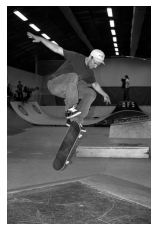

1/1 [==============================] - 0s 28ms/step
man in jeans and tie is doing trick


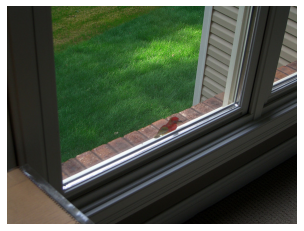

1/1 [==============================] - 0s 27ms/step
an old fashioned black cat sitting on the hood of truck


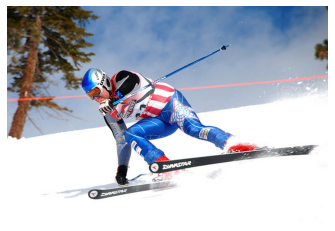

1/1 [==============================] - 0s 31ms/step
person on skis on the slopes of the snow


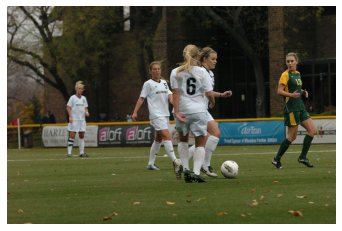

1/1 [==============================] - 0s 28ms/step
two soccer players fight to kick soccer balls


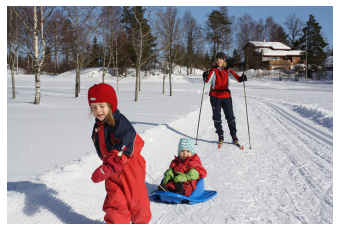

1/1 [==============================] - 0s 29ms/step
group of people standing on skis on the snow


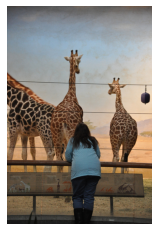

1/1 [==============================] - 0s 31ms/step
two giraffes are standing in the shade


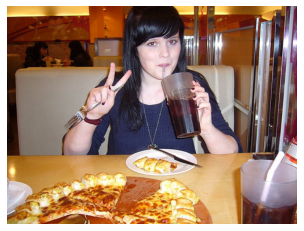

1/1 [==============================] - 0s 28ms/step
woman eating piece of pizza


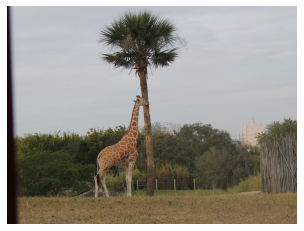

1/1 [==============================] - 0s 29ms/step
giraffe standing in the grass next to tree


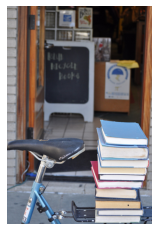

1/1 [==============================] - 0s 31ms/step
bike is parked on the tarmac of the building


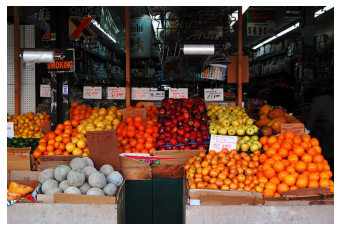

1/1 [==============================] - 0s 27ms/step
bunches of bananas are hanging from hooks


In [47]:
#####################################################################
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

for i in range(10):
    rn =  np.random.randint(0, 50)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    im = plt.imread(images+img_name)
    plt.imshow(im)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)

In [51]:
#evaluate model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        # generate description
        yhat = predict_caption(photos['/'+str(key)+'.jpg'].reshape((1,2048)))
        #store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

	# calculate BLEU score
    bl1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bl2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bl3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bl4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    print('BLEU-1: %f' % bl1)
    print('BLEU-2: %f' % bl2)
    print('BLEU-3: %f' % bl3)
    print('BLEU-4: %f' % bl4)

    # meteor score
    mt = 0
    for i in range(len(predicted)):
        mt += round(meteor_score(actual[i], predicted[i]),4)
    mt = mt/len(predicted)
    print('METEOR: %f' % mt)

    file = open(result_file,"a")
    file.write('\nBLEU-1: %f' % bl1)
    file.write('\nBLEU-2: %f' % bl2)
    file.write('\nBLEU-3: %f' % bl3)
    file.write('\nBLEU-4: %f' % bl4)
    file.write("\nMETEOR %f" %mt)
 
# load the model
filename = saved_path + "model_weights/model_9.h5"
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, encoding_test, word_to_idx, max_len)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  0%|          | 0/1000 [00:00<?, ?it/s]

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.469841
BLEU-2: 0.285067
BLEU-3: 0.204955
BLEU-4: 0.103164
METEOR: 0.282360


0it [00:00, ?it/s]

1/1 [==============================] - 0s 79ms/step
img_name /00009378.jpg


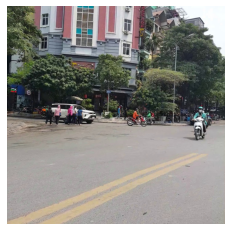

1/1 [==============================] - 0s 26ms/step
group of people standing next to motorcycle


In [52]:
traffic_dir = "/content/drive/MyDrive/traffic_data/images4_348"
list_img = []

for img_file_name in os.listdir(traffic_dir):
    list_img.append(img_file_name[:-4])

img_feature = {}
for ix, img in tqdm(enumerate(list_img)):
    img = traffic_dir + "/{}.jpg".format(list_img[ix])
    img_feature[img[len(traffic_dir):]] = encode_image(img)

traffic_storage = '/content/drive/MyDrive/Restnet50_LSTM_coco/caption_for_traffic_img/'
with open(traffic_storage+"encoded_images.pkl", "wb") as encoded_pickle:
    pickle.dump(img_feature, encoded_pickle)

for i in range(1):
    rn =  np.random.randint(0, 50)
    img_name = list(img_feature.keys())[rn]
    print('img_name', img_name)
    photo = img_feature[img_name].reshape((1,2048))

    im = plt.imread(traffic_dir+'/'+img_name)
    plt.imshow(im)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)
    
